# NLP Vectorization

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

## Learning Goals

SWBAT:

- normalize a lexicon with stemming and lemmatization
- run feature engineering algorithms for NLP
    - bag-of-Words
    - vectorization

In [3]:
corpus = pd.read_csv('data/satire_nosatire.csv')
first_document = corpus.iloc[0].body
manual_cleanup = [word.lower() for word in first_document.split(' ')]
manual_cleanup = [s.translate(str.maketrans('', '', string.punctuation))\
                  for s in manual_cleanup]
manual_cleanup = [token for token in manual_cleanup if\
                  token not in stopwords.words('english')]

In [4]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
first_doc = tokenizer.tokenize(first_document)
first_doc = [token.lower() for token in first_doc]
first_doc = [token for token in first_doc if token not in stopwords.words('english')]

### Stemming and Lemmatizing

#### Stemming
Most of the semantic meaning of a word is held in the root, which is usually the beginning of a word.  Conjugations and plurality do not change the semantic meaning. "eat", "eats", and "eating" all have essentially the same meaning. The rest is grammatical variation for the sake of marking things like tense or person or number.   

Stemmers consolidate similar words by chopping off the ends of the words.

![stemmer](img/stemmer.png)

There are different stemmers available.  The two we will use here are the **Porter** and **Snowball** stemmers.  A main difference between the two is how aggressively it stems, Porter being less aggressive.

In [5]:
p_stemmer = nltk.stem.PorterStemmer()
s_stemmer = nltk.stem.SnowballStemmer(language="english")

In [6]:
first_doc[0]

'noting'

In [7]:
p_stemmer.stem(first_doc[0])

'note'

In [8]:
s_stemmer.stem(first_doc[0])

'note'

In [9]:
for word in first_doc:
    p_word = p_stemmer.stem(word)
    s_word = s_stemmer.stem(word)
    
    if p_word != s_word:
        print(word, p_word, s_word)

jesus jesu jesus
can’t can’t can't
naperville napervil napervill
i’d i’d i'd
trump’s trump’ trump
that’s that’ that


In [10]:
first_doc = [p_stemmer.stem(word) for word in first_doc]

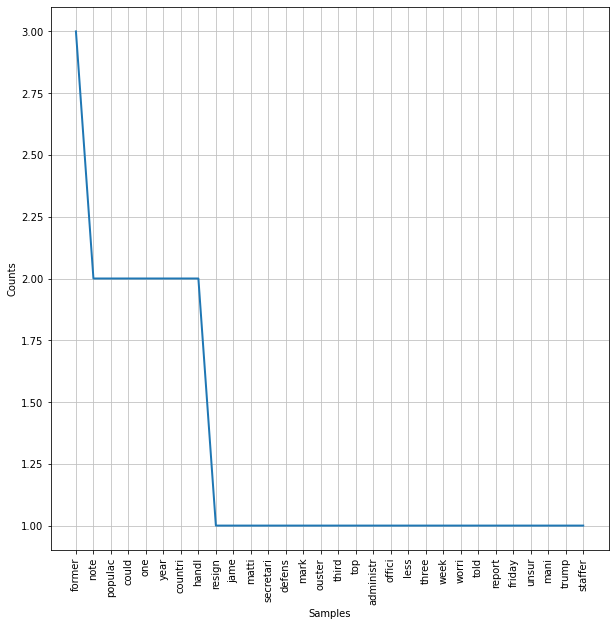

In [11]:
fdist = FreqDist(first_doc)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [12]:
print(f'Stemming did not reduce our token count: {len(set(first_doc))} unique tokens')

Stemming did not reduce our token count: 80 unique tokens


#### Lemmatizing

Lemmatizing is a bit more sophisticated than the stem choppers. Lemmatizing uses part-of-speech tagging to determine how to transform a word.

- Unlike Stemming, Lemmatization reduces the inflected words, properly ensuring that the root word belongs to the language. It can handle words such as "mouse", whose plural "mice" the stemmers would not lump together with the original. 

- In Lemmatization, the root word is called the "lemma". 

- A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

![lemmer](img/lemmer.png)

In [13]:
lemmatizer = nltk.stem.WordNetLemmatizer()


In [16]:
print(f'"Mice" becomes: {lemmatizer.lemmatize("mice")}')
print(f'"Noting" becomes: {lemmatizer.lemmatize(first_doc[0])}')

"Mice" becomes: mouse
"Noting" becomes: note


In [17]:
# However, look at the output below:
    
sentence = "He saw the trees get sawed down"
lemmed_sentence = [lemmatizer.lemmatize(token) for token in sentence.split(' ')]
lemmed_sentence

['He', 'saw', 'the', 'tree', 'get', 'sawed', 'down']

Lemmatizers depend, for their full functionality, on POS tagging, and **the default tag is 'noun'**.

With a little bit of work, we can POS tag our text.

In [20]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
first_doc = tokenizer.tokenize(first_document)
first_doc = [token.lower() for token in first_doc]
first_doc = [token for token in first_doc if token not in stopwords.words('english')]
corpus.loc[0].body

'Noting that the resignation of James Mattis as Secretary of Defense marked the ouster of the third top administration official in less than three weeks, a worried populace told reporters Friday that it was unsure how many former Trump staffers it could safely reabsorb. “Jesus, we can’t just take back these assholes all at once—we need time to process one before we get the next,” said 53-year-old Gregory Birch of Naperville, IL echoing the concerns of 323 million Americans in also noting that the country was only now truly beginning to reintegrate former national security advisor Michael Flynn. “This is just not sustainable. I’d say we can handle maybe one or two more former members of Trump’s inner circle over the remainder of the year, but that’s it. This country has its limits.” The U.S. populace confirmed that they could not handle all of these pieces of shit trying to rejoin society at once.'

In [21]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to /Users/wax/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [24]:
# Use nltk's pos_tag to tag our words
# Does a pretty good job, but does make some mistakes

first_doc_tagged = pos_tag(first_doc)
first_doc_tagged

[('noting', 'VBG'),
 ('resignation', 'NN'),
 ('james', 'NNS'),
 ('mattis', 'VBP'),
 ('secretary', 'NN'),
 ('defense', 'NN'),
 ('marked', 'VBD'),
 ('ouster', 'JJ'),
 ('third', 'JJ'),
 ('top', 'JJ'),
 ('administration', 'NN'),
 ('official', 'NN'),
 ('less', 'JJR'),
 ('three', 'CD'),
 ('weeks', 'NNS'),
 ('worried', 'VBD'),
 ('populace', 'NN'),
 ('told', 'VBD'),
 ('reporters', 'NNS'),
 ('friday', 'JJ'),
 ('unsure', 'JJ'),
 ('many', 'JJ'),
 ('former', 'JJ'),
 ('trump', 'NN'),
 ('staffers', 'NNS'),
 ('could', 'MD'),
 ('safely', 'RB'),
 ('reabsorb', 'VB'),
 ('jesus', 'NN'),
 ('can’t', 'NNS'),
 ('take', 'VBP'),
 ('back', 'RP'),
 ('assholes', 'NNS'),
 ('need', 'VBP'),
 ('time', 'NN'),
 ('process', 'NN'),
 ('one', 'CD'),
 ('get', 'NN'),
 ('next', 'IN'),
 ('said', 'VBD'),
 ('year', 'NN'),
 ('old', 'JJ'),
 ('gregory', 'NN'),
 ('birch', 'NN'),
 ('naperville', 'FW'),
 ('il', 'NN'),
 ('echoing', 'VBG'),
 ('concerns', 'NNS'),
 ('million', 'CD'),
 ('americans', 'NNS'),
 ('also', 'RB'),
 ('noting', 'VBG

In [27]:
# Then transform the tags into the tags of our lemmatizers

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [28]:
first_doc_tagged = [(token[0], get_wordnet_pos(token[1]))
             for token in first_doc_tagged]

In [31]:
first_doc_tagged

[('noting', 'v'),
 ('resignation', 'n'),
 ('james', 'n'),
 ('mattis', 'v'),
 ('secretary', 'n'),
 ('defense', 'n'),
 ('marked', 'v'),
 ('ouster', 'a'),
 ('third', 'a'),
 ('top', 'a'),
 ('administration', 'n'),
 ('official', 'n'),
 ('less', 'a'),
 ('three', 'n'),
 ('weeks', 'n'),
 ('worried', 'v'),
 ('populace', 'n'),
 ('told', 'v'),
 ('reporters', 'n'),
 ('friday', 'a'),
 ('unsure', 'a'),
 ('many', 'a'),
 ('former', 'a'),
 ('trump', 'n'),
 ('staffers', 'n'),
 ('could', 'n'),
 ('safely', 'r'),
 ('reabsorb', 'v'),
 ('jesus', 'n'),
 ('can’t', 'n'),
 ('take', 'v'),
 ('back', 'r'),
 ('assholes', 'n'),
 ('need', 'v'),
 ('time', 'n'),
 ('process', 'n'),
 ('one', 'n'),
 ('get', 'n'),
 ('next', 'n'),
 ('said', 'v'),
 ('year', 'n'),
 ('old', 'a'),
 ('gregory', 'n'),
 ('birch', 'n'),
 ('naperville', 'n'),
 ('il', 'n'),
 ('echoing', 'v'),
 ('concerns', 'n'),
 ('million', 'n'),
 ('americans', 'n'),
 ('also', 'r'),
 ('noting', 'v'),
 ('country', 'n'),
 ('truly', 'r'),
 ('beginning', 'v'),
 ('reinteg

In [29]:
first_doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in first_doc_tagged]

In [30]:
first_doc_lemmed[:10]

['note',
 'resignation',
 'james',
 'mattis',
 'secretary',
 'defense',
 'mark',
 'ouster',
 'third',
 'top']

In [32]:
print(f'There are {len(set(first_doc_lemmed))} unique lemmas.')

There are 79 unique lemmas.


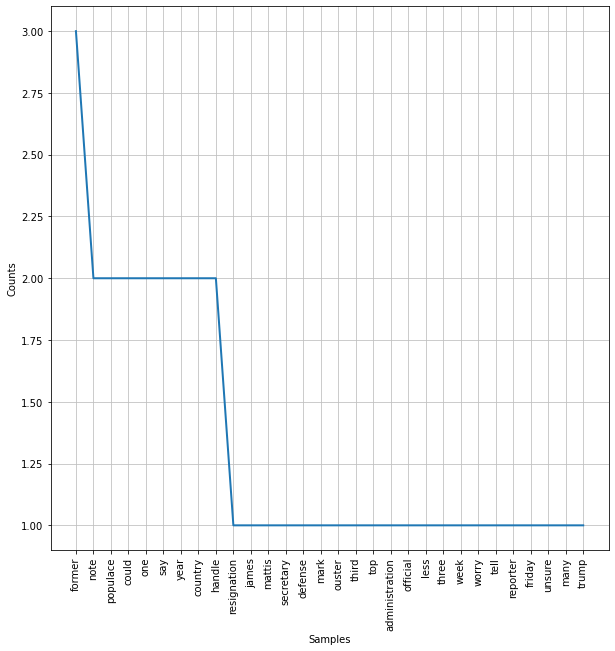

In [33]:
fdist = FreqDist(first_doc_lemmed)
plt.figure(figsize=(10, 10))
fdist.plot(30);

## Part 3. Feature Engineering for NLP

The machine learning algorithms we have encountered so far represent features as the variables that take on different value for each observation. For example, we represent individuals with distinct education levels, incomes, and such. However, in NLP, features are represented in a very different way. In order to pass text data to machine learning algorithms and perform classification, we need to represent the features in a sensible way. One such method is called **Bag-of-words (BoW)**.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

It is called a “bag” of words **because any information about the order or structure of words in the document is discarded**. The model is only concerned with whether known words occur in the document, not with **where** they may occur in the document. The intuition behind BoW is that a document is similar to another if they have similar contents. The Bag of Words method can be represented as a **Document Term Matrix**, in which each column is a unique vocabulary n-gram and each observation is a document. Consider, for example, the following **corpus** of documents:

- Document 1: "I love dogs."
- Document 2: "I love cats."
- Document 3: "I love all animals."
- Document 4: "I hate dogs."

This corpus can be represented as:

$\downarrow$Doc\|Word$\rightarrow$|I|love|dogs|cats|all|animals|hate
-|-|-|-|-|-|-|-
Document_1|1|1|1|0|0|0|0
Document_2|1|1|0|1|0|0|0
Document_3|1|1|0|0|1|1|0
Document_4|1|0|1|0|0|0|1

### Vectorization

In order to get these tokens from our documents, we're going to use tools called "vectorizers".

The most straightforward vectorizer in `sklearn.feature_extraction.text` is the `CountVectorizer`, which will simply count the number of each word type in each document.

#### `CountVectorizer`

In [36]:
# implementing it in python

# Convert a collection of text documents to a matrix of token counts

vec = CountVectorizer()
X = vec.fit_transform([" ".join(first_doc_lemmed)])


df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,administration,advisor,also,american,asshole,back,begin,birch,can,circle,...,time,top,truly,trump,try,two,unsure,week,worry,year
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2


That is not very exciting for one document. The idea is to make a document term matrix for all of the words in our corpus.

In [37]:
corpus

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1
...,...,...
995,Britain’s opposition leader Jeremy Corbyn wou...,0
996,Turkey will take over the fight against Islam...,0
997,Malaysia is seeking $7.5 billion in reparatio...,0
998,An Israeli court sentenced a Palestinian to 1...,0


In [38]:
custom_sw = stopwords.words('english')

In [39]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=custom_sw)
X = vec.fit_transform(corpus.body[0:2])

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,adding,administration,advisor,also,americans,another,assholes,back,bank,beginning,...,want,wants,weeks,whether,whole,witnesses,work,worried,year,yet
0,0,1,1,1,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,2,0
1,1,0,0,0,0,1,0,1,1,0,...,2,1,1,1,1,1,1,0,0,1


In [40]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=custom_sw,
                      ngram_range=[1, 2])
X = vec.fit_transform(corpus.body[0:2])

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,adding,adding wants,administration,administration official,advisor,advisor michael,also,also noting,americans,americans also,...,witnesses want,work,work investigating,worried,worried populace,year,year country,year old,yet,yet another
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,1,1,2,1,1,0,0
1,1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1


Our document term matrix gets bigger and bigger, with more and more zeros, becoming sparser and sparser.

In [41]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=custom_sw,
                      ngram_range=[1, 2])
X = vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,aa,aa united,aaaaaaah,aaaaaaah aaaaaah,aaaaaah,aaaaaah deal,aaaaargh,aaaaargh falls,aaaah,aaaah internet,...,zuercher kantonalbank,zverev,zverev two,zych,zych mother,zych whose,zzouss,zzzzzst,zzzzzst compilation,zzzzzst shut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can set upper and lower limits to the word frequency:

In [42]:
corpus.body

0      Noting that the resignation of James Mattis as...
1      Desperate to unwind after months of nonstop wo...
2      Nearly halfway through his presidential term, ...
3      Attempting to make amends for gross abuses of ...
4      Decrying the Senate’s resolution blaming the c...
                             ...                        
995     Britain’s opposition leader Jeremy Corbyn wou...
996     Turkey will take over the fight against Islam...
997     Malaysia is seeking $7.5 billion in reparatio...
998     An Israeli court sentenced a Palestinian to 1...
999     At least 22 people have died due to landslide...
Name: body, Length: 1000, dtype: object

In [43]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=custom_sw, ngram_range=[1,2],
                      min_df=2, max_df=25)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df_cv

,aapl,aaron,aaron ross,ab,abandon,abandon conservatives,abandoned,abandoned grassroots,abandoning,abandoning quarter,...,zone,zone eu,zones,zoo,zoo closed,zooming,zor,zte,zte corp,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### `TfidfVectorizer`

There are many schemas for determining the values of each entry in a document term matrix, and one of the most common uses the TF-IDF algorithm -- "Term Frequency-Inverse Document Frequency". Essentially, tf-idf *normalizes* the raw count of the document term matrix. And it represents how important a word is in the given document. 

> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

- TF (Term Frequency)
Term frequency is the frequency of the word in the document divided by the total words in the document.

- IDF (inverse document frequency)
Inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is generally calculated as the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):

$$idf(w) = log (\frac{number\ of\ documents}{num\ of\ documents\ containing\ w})$$

tf-idf is the product of term frequency and inverse document frequency, or tf * idf. 

In [44]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=custom_sw)
X = tf_vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names())
df.head()

,aa,aaaaaaah,aaaaaah,aaaaargh,aaaah,aaah,aaargh,aah,aahing,aap,...,zoos,zor,zozovitch,zte,zuckerberg,zuercher,zverev,zych,zzouss,zzzzzst
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
corpus.iloc[313].body

'Power nerds, these are a special breed of techie nerds who want to take over the world with their technological prowess. From the birth of the World Wide Web, these power nerds have created and grown companies that are now monopolies controlling every facet of people’s lives. Smartphones, apps, search engines, social networks – power nerds are in everything, their power increases daily as more millions of people use their networks. Power nerds are ruthless, they are creatures who do not balk in crushing their opponents completely without mercy and their greed for complete controlling power over everything is boundless. To quote a few examples of companies that are run by ruthless power nerds, we can of course cite Facebook, Twitter, Amazon and Google. These companies are not only seeking to rule and control everything, they also are using their power to manipulate data taken from their platforms to make money and increase their influence, as well as shut down any voices that are not l

In [46]:
df.iloc[313].sort_values(ascending=False)[:10]

nerds         0.600312
power         0.396376
companies     0.168090
billions      0.140697
facebook      0.129217
ruthless      0.127204
company       0.106695
evil          0.104667
zuckerberg    0.098663
people        0.095626
Name: 313, dtype: float64

Let's compare the tfidf to the count vectorizer output for one document.

In [47]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=custom_sw)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df_cv

,aa,aaaaaaah,aaaaaah,aaaaargh,aaaah,aaah,aaargh,aah,aahing,aap,...,zoos,zor,zozovitch,zte,zuckerberg,zuercher,zverev,zych,zzouss,zzzzzst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_cv.iloc[313].sort_values(ascending=False)[:10]

power        18
nerds        11
people        7
companies     6
billions      4
facebook      4
one           4
also          4
company       4
data          3
Name: 313, dtype: int64

The tfidf lessoned the importance of some of the more common words, including a word, "also", which might have made it into the stopword list.

It also assigns "nerds" more weight than power.  

In [49]:
print(f'"Nerds" only shows up in document 313: {len(df_cv[df.nerds!=0])} document.')
print(f'"Power" shows up in {len(df_cv[df.power!=0])} documents!')

"Nerds" only shows up in document 313: 1 document.
"Power" shows up in 147 documents!


All the words are stored in a `.vocabulary_` attribute:

In [50]:
tf_vec.vocabulary_

{'noting': 14228,
 'resignation': 17453,
 'james': 11083,
 'mattis': 12876,
 'secretary': 18493,
 'defense': 5328,
 'marked': 12753,
 'ouster': 14711,
 'third': 21062,
 'top': 21291,
 'administration': 293,
 'official': 14445,
 'less': 12042,
 'three': 21096,
 'weeks': 22859,
 'worried': 23186,
 'populace': 15784,
 'told': 21257,
 'reporters': 17365,
 'friday': 8389,
 'unsure': 22126,
 'many': 12705,
 'former': 8261,
 'trump': 21633,
 'staffers': 19832,
 'could': 4654,
 'safely': 18072,
 'reabsorb': 16838,
 'jesus': 11159,
 'take': 20693,
 'back': 1540,
 'assholes': 1254,
 'need': 13936,
 'time': 21177,
 'process': 16146,
 'one': 14516,
 'get': 8762,
 'next': 14045,
 'said': 18088,
 'year': 23301,
 'old': 14477,
 'gregory': 9106,
 'birch': 2136,
 'naperville': 13830,
 'il': 10220,
 'echoing': 6555,
 'concerns': 4203,
 'million': 13240,
 'americans': 723,
 'also': 658,
 'country': 4674,
 'truly': 21632,
 'beginning': 1905,
 'reintegrate': 17182,
 'national': 13870,
 'security': 18511,
 

#### `HashingVectorizer`

There is also a hashing vectorizer, which will encrypt all the words of the corpus.

In [51]:
hvec = HashingVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                         stop_words=custom_sw)
X = hvec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray())
df_cv

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.167248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Some rules of thumb about these vectorizers:

**Tf-Idf**: Probably the most commonly used. Useful when the goal is to distinguish the **content** of documents from others in the corpus.

**Count**: Useful when the words themselves matter. If the goal is instead about identifying authors by their words, then the fact that some word appears in many documents of the corpus may be important.

**Hashing**: The advantage here is speed and low memory usage. The disadvantage is that you lose the identities of the words being tokenized. Useful for very large datasets where the ultimate model may be a bit of a black box.

## Exercise

For a final exercise, work through the following:

Create a document term matrix of the 1000-document corpus. The vocabulary should have no stopwords, numbers, or punctuation, and it should be lemmatized. Use a `TfidfVectorizer`.